# **Assignment 3 - Group 3**

# License

Copyright 2021 - 2025 Patrick Hall (jphall@gwu.edu) & 
Montenegro Lopez (miranda.montenegrolopez@gwu.edu),
Bethel Mandizha (bethel.mandizha@gwmail.gwu.edu), 
Rahul Saha (rahulsanasony@gmail.com), 
Zeyu Wang (zywang@gwu.edu)

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0  

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

### **Importing Necessary Libraries**

In [1]:
#Data manipulation, plotting and metrics
import numpy as np
import pandas as pd
import operator
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns  
import datetime   
import time  

#Model modules
import itertools 
from interpret import show
from interpret.glassbox import ExplainableBoostingClassifier
from interpret.perf import ROC 

from sklearn.metrics import accuracy_score, f1_score, log_loss, mean_squared_error, roc_auc_score
import random

#Setting numpy seed for better reproducibility
SEED = 12345 
np.random.seed(SEED)

#Setting number of threads
NTHREAD = 4

#### Starting the Global Timer

In [2]:
tic = time.time()

### **Importing Applicable Data**

In [3]:
#Importing pre-processed training data and showing first 5 lines of the dataset
train_data = pd.read_csv('/Users/Zeyu/Downloads/hmda_train_preprocessed.csv')
train_data.head()

,row_id,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,...,conforming,debt_to_income_ratio_missing,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,high_priced
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,...,1,0,-0.514393,0.333922,0.244394,-0.215304,-0.535932,-0.040307,0.854601,0
1,1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,1,0,-0.118642,0.268727,0.244394,-0.215304,-0.227585,-0.018133,-0.425131,0
2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,0,-0.778227,0.228996,-4.091747,4.610857,-0.720941,-0.032338,0.123326,0
3,3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,1,0,-0.074670,-1.150240,0.244394,-0.215304,0.358276,-0.018133,-0.425131,0
4,4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,NaN,NaN,...,1,0,-0.602338,0.552520,0.244394,-0.215304,-0.628437,-0.038228,0.763191,0


In [4]:
#Importing pre-processed testing data and showing first 5 lines of the dataset
test_data = pd.read_csv('/Users/Zeyu/Downloads/hmda_test_preprocessed.csv')
test_data.head()

,row_id,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,...,term_360,conforming,debt_to_income_ratio_missing,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std
0,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1,1,0,-0.514393,-0.039293,0.244394,-0.215304,-0.474263,-0.017786,0.854601
1,1,0.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,...,1,1,0,-0.162614,0.126830,0.244394,-0.215304,-0.227585,-0.015014,-0.425131
2,2,NaN,NaN,NaN,NaN,NaN,1.0,0.0,NaN,NaN,...,1,1,0,-0.646310,0.552520,0.244394,-0.215304,-0.659271,-0.033378,-0.425131
3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,0,0,3.662982,0.133614,0.244394,-0.215304,2.763389,0.025177,0.306144
4,4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,1,1,0,-0.338504,0.552520,0.244394,-0.215304,-0.443428,-0.027834,0.306144


#### Assigning modeling roles for the data

In [5]:
#Setting target and features for the data
target = 'high_priced'
demographic_cols = ['black', 'asian','white', 'amind', 'hipac', 'hispanic', 'non_hispanic', 'male', 'female', 'agegte62', 'agelt62']
features = [col for col in train_data.columns if col not in demographic_cols + ['row_id',target]]

print('target =', target)
print('predictors =', features)

target = high_priced
predictors = ['term_360', 'conforming', 'debt_to_income_ratio_missing', 'loan_amount_std', 'loan_to_value_ratio_std', 'no_intro_rate_period_std', 'intro_rate_period_std', 'property_value_std', 'income_std', 'debt_to_income_ratio_std']


In [6]:
#Preserve exact reproducibility for this cell
np.random.seed(SEED) 

#Choosing a 70/30 train/test split 
split_ratio = 0.7

#Execute split
split = np.random.rand(len(train_data)) < split_ratio
train = train_data[split]
valid = train_data[~split]

#Summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Validation data rows = %d, columns = %d' % (valid.shape[0], valid.shape[1]))

Train data rows = 112253, columns = 23
Validation data rows = 48085, columns = 23


### **Setting up Model - EBM**

In [7]:
def ebm_grid(train, valid, x_names, y_name, gs_params=None, n_models=None, early_stopping_rounds=None, seed=None,
             air_reference=None, air_protected=None, air_cut=None, verbose=False):

    """ Performs a random grid search over n_models and gs_params.
        Optionally considers random feature sets and AIR.
        Coupled to get_confusion_matrix() and air().

    :param train: Training data as Pandas DataFrame.
    :param valid: Validation data as Pandas DataFrame.
    :param x_names: Names of input features.
    :param y_name: Name of target feature.
    :param gs_params: Dictionary of lists of potential EBM parameters over which to search.
    :param n_models: Number of random models to evaluate.
    :param early_stopping_rounds: EBM early stopping rounds.
    :param seed: Random seed for better interpretability.
    :param air_reference: Reference group for AIR calculation, optional.
    :param air_protected: Protected group for AIR calculation, optional.
    :param air_cut: Cutoff for AIR calculation, optional.
    :param verbose: Whether to print intermediate acceptance rates, default False.
    :return: Tuple: (Best EBM model, Pandas DataFrame of models to select from)

    """

    # init returned frame
    do_air = all(v is not None for v in [air_reference, air_protected])
    if do_air:
        columns = list(gs_params.keys()) + ['features', 'auc', 'air']
    else:
        columns = list(gs_params.keys()) + ['auc']
    ebm_grid_frame = pd.DataFrame(columns=columns)

    # cartesian product of gs_params
    keys, values = zip(*gs_params.items())
    experiments = [dict(zip(keys, v)) for v in itertools.product(*values)]

    # preserve exact reproducibility for this function
    np.random.seed(SEED)

    # select randomly from cartesian product space
    selected_experiments = np.random.choice(len(experiments), n_models)

    # set global params for seed, etc.
    params = {'n_jobs': NTHREAD,
              'early_stopping_rounds': early_stopping_rounds,
              'random_state': SEED}

    # init grid search loop
    best_candidate = None
    best_score = 0

    # grid search loop
    for i, exp in enumerate(selected_experiments):

        params.update(experiments[exp])  # override global params with current grid run params

        print('Grid search run %d/%d:' % (int(i + 1), int(n_models)))
        print('Training with parameters:', params)

        # train
        ebm = ExplainableBoostingClassifier(**params)

        # conditionally select random features
        features = x_names
        if do_air:
            n_features = random.randrange(len(x_names)) + 1
            features = random.sample(x_names, n_features)
        candidate = ebm.fit(train[features], train[y_name])

        # calculate AUC
        ebm_perf = ROC(ebm.predict_proba).explain_perf(valid[features], valid[y_name])
        candidate_best_score = ebm_perf._internal_obj['overall']['auc']

        # compose values to add to ebm_grid_frame
        row_dict = params.copy()
        row_dict['auc'] = candidate_best_score
        if do_air:
            # collect random feature set
            row_dict['features'] = features
            # conditionally calculate AIR
            valid_phat = valid.copy(deep=True)
            valid_phat['phat'] = candidate.predict_proba(valid[features])[:, 1]
            cm_ref = get_confusion_matrix(valid_phat, y_name, 'phat', by=air_reference, level=1, cutoff=air_cut, verbose=verbose)
            cm_pro = get_confusion_matrix(valid_phat, y_name, 'phat', by=air_protected, level=1, cutoff=air_cut, verbose=verbose)
            air_ = air({air_reference: cm_ref, air_protected: cm_pro}, air_reference, air_protected, verbose=verbose)
            row_dict['air'] = air_
            row_dict['features'] = ', '.join(row_dict['features'])
            del valid_phat

        # append run to ebm_grid_frame
        ebm_grid_frame = pd.concat([ebm_grid_frame, pd.DataFrame(row_dict, index=[i])], axis=0)

        # determine if current model is better than previous best
        if candidate_best_score > best_score:
            best_score = candidate_best_score
            best_ebm = candidate
            print('Grid search new best score discovered at iteration %d/%d: %.4f.' %
                             (int(i + 1), int(n_models), candidate_best_score))

        print('---------- ----------')

        del row_dict
        del ebm

    return best_ebm, ebm_grid_frame

#### Fit EBM with random grid search

Grid search has been modified by running a larger `number of models` (n=150), adding 1,024, 2,048 and 3,072 as options for adding `max_bins`, adding 24 and 40 as an option for `max_interaction_bins`, adding 7 as an option for the `max_leaves`, and defining 5 `cross-validation folds` instead of the standard 3.

In [8]:
#Dictionary of hyperparameter value lists for grid search
gs_params = {'max_bins': [128, 256, 512, 1024, 2048, 3072],
             'max_interaction_bins': [16, 24, 32, 40, 64],
             'interactions': [5, 10, 15],
             'outer_bags': [4, 8, 12], 
             'inner_bags': [0, 4],
             'learning_rate': [0.001, 0.01, 0.05],
             'validation_size': [0.1, 0.25, 0.5],
             'min_samples_leaf': [1, 2, 5, 10],
             'max_leaves': [1, 3, 5, 7]}

#Start local timer
ebm_tic = time.time()

#EBM grid search
best_ebm = ebm_grid(train, valid, features, target, gs_params=gs_params, n_models=50, 
                    early_stopping_rounds=100, seed=SEED)

#End local timer
ebm_toc = time.time() - ebm_tic
print('EBM training completed in %.2f s.' % (ebm_toc))

Grid search run 1/50:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 3072, 'max_interaction_bins': 64, 'interactions': 15, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.1, 'min_samples_leaf': 2, 'max_leaves': 3}


C:\Users\Zeyu\AppData\Local\Temp\ipykernel_11064\3173739067.py:90: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ebm_grid_frame = pd.concat([ebm_grid_frame, pd.DataFrame(row_dict, index=[i])], axis=0)


Grid search new best score discovered at iteration 1/50: 0.8252.
---------- ----------
Grid search run 2/50:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 16, 'interactions': 15, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.001, 'validation_size': 0.25, 'min_samples_leaf': 1, 'max_leaves': 3}
---------- ----------
Grid search run 3/50:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 24, 'interactions': 10, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.1, 'min_samples_leaf': 10, 'max_leaves': 5}
---------- ----------
Grid search run 4/50:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 16, 'interactions': 15, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.25, '

#### Computing the Validation AUC for this Model

In [11]:
#Showing the highest validation score found from the grid search conducted
best_ebm_model = best_ebm[0]

best_ebm_perf = ROC(best_ebm_model.predict_proba).explain_perf(valid[features], valid[target])
print('Validation AUC: %.4f.' % best_ebm_perf._internal_obj['overall']['auc'])

Validation AUC: 0.8255.


#### Score Validation with Model

In [13]:
best_ebm_phat = pd.DataFrame(best_ebm_model.predict_proba(valid[features])[:, 1], columns=['phat'])
best_ebm_phat = pd.concat([valid.reset_index(drop=True), best_ebm_phat], axis=1)
best_ebm_phat.head()

,row_id,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,...,debt_to_income_ratio_missing,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,high_priced,phat
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,...,0,-0.514393,0.333922,0.244394,-0.215304,-0.535932,-0.040307,0.854601,0,0.185431
1,6,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0,-0.426448,0.355249,0.244394,-0.215304,-0.474263,-0.020904,1.037419,0,0.312181
2,8,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,0,0.277109,0.142995,0.244394,-0.215304,0.111598,-0.019865,0.031916,0,0.024768
3,10,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,0,-0.382476,-0.240432,0.244394,-0.215304,-0.320089,-0.028181,0.946010,0,0.016959
4,11,0.0,0.0,1.0,0.0,0.0,1.0,0.0,NaN,NaN,...,0,0.101220,-0.266529,0.244394,-0.215304,0.111598,0.016515,-1.156406,0,0.004471


#### Utility function to calculate confusion matrices by demographic group

In [14]:
def get_confusion_matrix(frame, y, yhat, by=None, level=None, cutoff=0.5, verbose=True):

    """ Creates confusion matrix from pandas dataframe of y and yhat values, can be sliced
        by a variable and level.

        :param frame: Pandas dataframe of actual (y) and predicted (yhat) values.
        :param y: Name of actual value column.
        :param yhat: Name of predicted value column.
        :param by: By variable to slice frame before creating confusion matrix, default None.
        :param level: Value of by variable to slice frame before creating confusion matrix, default None.
        :param cutoff: Cutoff threshold for confusion matrix, default 0.5.
        :param verbose: Whether to print confusion matrix titles, default True.
        :return: Confusion matrix as pandas dataframe.

    """

    # determine levels of target (y) variable
    # sort for consistency
    level_list = list(frame[y].unique())
    level_list.sort(reverse=True)

    # init confusion matrix
    cm_frame = pd.DataFrame(columns=['actual: ' +  str(i) for i in level_list],
                            index=['predicted: ' + str(i) for i in level_list])

    # don't destroy original data
    frame_ = frame.copy(deep=True)

    # convert numeric predictions to binary decisions using cutoff
    dname = 'd_' + str(y)
    frame_[dname] = np.where(frame_[yhat] > cutoff , 1, 0)

    # slice frame
    if (by is not None) & (level is not None):
        frame_ = frame_[frame[by] == level]

    # calculate size of each confusion matrix value
    for i, lev_i in enumerate(level_list):
        for j, lev_j in enumerate(level_list):
            cm_frame.iat[j, i] = frame_[(frame_[y] == lev_i) & (frame_[dname] == lev_j)].shape[0]
            # i, j vs. j, i nasty little bug ... updated 8/30/19

    # output results
    if verbose:
        if by is None:
            print('Confusion matrix:')
        else:
            print('Confusion matrix by ' + by + '=' + str(level))

    return cm_frame


#### Utility function to calculate AIR

In [15]:
def air(cm_dict, reference_key, protected_key, verbose=True):

    """ Calculates the adverse impact ratio as a quotient between protected and
        reference group acceptance rates: protected_prop/reference_prop.
        Optionally prints intermediate values. ASSUMES 0 IS "POSITIVE" OUTCOME!

        :param cm_dict: Dictionary of demographic group confusion matrices.
        :param reference_key: Name of reference group in cm_dict as a string.
        :param protected_key: Name of protected group in cm_dict as a string.
        :param verbose: Whether to print intermediate acceptance rates, default True.
        :return: AIR.

    """

    eps = 1e-20 # numeric stability and divide by 0 protection

    # reference group summary
    reference_accepted = float(cm_dict[reference_key].iat[1,0] + cm_dict[reference_key].iat[1,1]) # predicted 0's
    reference_total = float(cm_dict[reference_key].sum().sum())
    reference_prop = reference_accepted/reference_total
    if verbose:
        print(reference_key.title() + ' proportion accepted: %.3f' % reference_prop)

    # protected group summary
    protected_accepted = float(cm_dict[protected_key].iat[1,0] + cm_dict[protected_key].iat[1,1]) # predicted 0's
    protected_total = float(cm_dict[protected_key].sum().sum())
    protected_prop = protected_accepted/protected_total
    if verbose:
        print(protected_key.title() + ' proportion accepted: %.3f' % protected_prop)

    # return adverse impact ratio
    if np.isclose(protected_accepted, 0.0):
        return np.nan
    else:
        return ((protected_prop + eps)/(reference_prop + eps))


#### Utility function to select probability cutoff by F1

In [16]:
def get_max_f1_frame(frame, y, yhat, res=0.01, air_reference=None, air_protected=None, verbose=False):

    """ Utility function for finding max. F1.
        Coupled to get_confusion_matrix() and air().
        Assumes 1 is the marker for class membership.

        :param frame: Pandas dataframe of actual (y) and predicted (yhat) values.
        :param y: Known y values.
        :param yhat: Model scores.
        :param res: Resolution over which to search for max. F1, default 0.01.
        :param air_reference: Reference group for AIR calculation, optional.
        :param air_protected: Protected group for AIR calculation, optional.
        :return: Pandas DataFrame of cutoffs to select from.

    """

    do_air = all(v is not None for v in [air_reference, air_protected])

    # init frame to store f1 at different cutoffs
    if do_air:
        columns = ['cut', 'f1', 'acc', 'air']
    else:
        columns = ['cut', 'f1', 'acc']
    f1_frame = pd.DataFrame(columns=['cut', 'f1', 'acc'])

    # copy known y and score values into a temporary frame
    temp_df = frame[[y, yhat]].copy(deep=True)

    # find f1 at different cutoffs and store in acc_frame
    for i, cut in enumerate(np.arange(0, 1 + res, res)):
        temp_df['decision'] = np.where(temp_df.iloc[:, 1] > cut, 1, 0)
        f1 = f1_score(temp_df.iloc[:, 0], temp_df['decision'])
        acc = accuracy_score(temp_df.iloc[:, 0], temp_df['decision'])
        row_dict = {'cut': cut, 'f1': f1, 'acc': acc}
        if do_air:
            # conditionally calculate AIR
            cm_ref = get_confusion_matrix(frame, y, yhat, by=air_reference, level=1, cutoff=cut, verbose=verbose)
            cm_pro = get_confusion_matrix(frame, y, yhat, by=air_protected, level=1, cutoff=cut, verbose=verbose)
            air_ = air({air_reference: cm_ref, air_protected: cm_pro}, air_reference, air_protected, verbose=verbose)
            row_dict['air'] = air_

        f1_frame = pd.concat([f1_frame, pd.DataFrame(row_dict, index=[i])], axis=0)

    del temp_df

    return f1_frame


#### Utility function for random grid search

In [17]:
def ebm_grid(train, valid, x_names, y_name, gs_params=None, n_models=None, early_stopping_rounds=None, seed=None,
             air_reference=None, air_protected=None, air_cut=None, verbose=False):

    """ Performs a random grid search over n_models and gs_params.
        Optionally considers random feature sets and AIR.
        Coupled to get_confusion_matrix() and air().

    :param train: Training data as Pandas DataFrame.
    :param valid: Validation data as Pandas DataFrame.
    :param x_names: Names of input features.
    :param y_name: Name of target feature.
    :param gs_params: Dictionary of lists of potential EBM parameters over which to search.
    :param n_models: Number of random models to evaluate.
    :param early_stopping_rounds: EBM early stopping rounds.
    :param seed: Random seed for better interpretability.
    :param air_reference: Reference group for AIR calculation, optional.
    :param air_protected: Protected group for AIR calculation, optional.
    :param air_cut: Cutoff for AIR calculation, optional.
    :param verbose: Whether to print intermediate acceptance rates, default False.
    :return: Tuple: (Best EBM model, Pandas DataFrame of models to select from)

    """

    # init returned frame
    do_air = all(v is not None for v in [air_reference, air_protected])
    if do_air:
        columns = list(gs_params.keys()) + ['features', 'auc', 'air']
    else:
        columns = list(gs_params.keys()) + ['auc']
    ebm_grid_frame = pd.DataFrame(columns=columns)

    # cartesian product of gs_params
    keys, values = zip(*gs_params.items())
    experiments = [dict(zip(keys, v)) for v in itertools.product(*values)]

    # preserve exact reproducibility for this function
    np.random.seed(SEED)

    # select randomly from cartesian product space
    selected_experiments = np.random.choice(len(experiments), n_models)

    # set global params for seed, etc.
    params = {'n_jobs': NTHREAD,
              'early_stopping_rounds': early_stopping_rounds,
              'random_state': SEED}

    # init grid search loop
    best_candidate = None
    best_score = 0

    # grid search loop
    for i, exp in enumerate(selected_experiments):

        params.update(experiments[exp])  # override global params with current grid run params

        print('Grid search run %d/%d:' % (int(i + 1), int(n_models)))
        print('Training with parameters:', params)

        # train
        ebm = ExplainableBoostingClassifier(**params)

        # conditionally select random features
        features = x_names
        if do_air:
            n_features = random.randrange(len(x_names)) + 1
            features = random.sample(x_names, n_features)
        candidate = ebm.fit(train[features], train[y_name])

        # calculate AUC
        ebm_perf = ROC(ebm.predict_proba).explain_perf(valid[features], valid[y_name])
        candidate_best_score = ebm_perf._internal_obj['overall']['auc']

        # compose values to add to ebm_grid_frame
        row_dict = params.copy()
        row_dict['auc'] = candidate_best_score
        if do_air:
            # collect random feature set
            row_dict['features'] = features
            # conditionally calculate AIR
            valid_phat = valid.copy(deep=True)
            valid_phat['phat'] = candidate.predict_proba(valid[features])[:, 1]
            cm_ref = get_confusion_matrix(valid_phat, y_name, 'phat', by=air_reference, level=1, cutoff=air_cut, verbose=verbose)
            cm_pro = get_confusion_matrix(valid_phat, y_name, 'phat', by=air_protected, level=1, cutoff=air_cut, verbose=verbose)
            air_ = air({air_reference: cm_ref, air_protected: cm_pro}, air_reference, air_protected, verbose=verbose)
            row_dict['air'] = air_
            row_dict['features'] = ', '.join(row_dict['features'])
            del valid_phat

        # append run to ebm_grid_frame
        ebm_grid_frame = pd.concat([ebm_grid_frame, pd.DataFrame(row_dict, index=[i])], axis=0)

        # determine if current model is better than previous best
        if candidate_best_score > best_score:
            best_score = candidate_best_score
            best_ebm = candidate
            print('Grid search new best score discovered at iteration %d/%d: %.4f.' %
                             (int(i + 1), int(n_models), candidate_best_score))

        print('---------- ----------')

        del row_dict
        del ebm

    return best_ebm, ebm_grid_frame

#### Find optimal cutoff based on F1

In [18]:
f1_frame = get_max_f1_frame(best_ebm_phat, target, 'phat')

print(f1_frame)
print()

max_f1 = f1_frame['f1'].max()
best_cut = f1_frame.loc[int(f1_frame['f1'].idxmax()), 'cut'] #idxmax() returns the index of the maximum value
acc = f1_frame.loc[int(f1_frame['f1'].idxmax()), 'acc']

print('Best EBM F1: %.4f achieved at cutoff: %.2f with accuracy: %.4f.' % (max_f1, best_cut, acc))

C:\Users\Zeyu\AppData\Local\Temp\ipykernel_11064\1356307587.py:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  f1_frame = pd.concat([f1_frame, pd.DataFrame(row_dict, index=[i])], axis=0)


      cut        f1       acc
0    0.00  0.173860  0.095206
1    0.01  0.231104  0.374649
2    0.02  0.261170  0.474514
3    0.03  0.278802  0.525736
4    0.04  0.295308  0.567058
..    ...       ...       ...
96   0.96  0.000000  0.904794
97   0.97  0.000000  0.904794
98   0.98  0.000000  0.904794
99   0.99  0.000000  0.904794
100  1.00  0.000000  0.904794

[101 rows x 3 columns]

Best EBM F1: 0.3662 achieved at cutoff: 0.20 with accuracy: 0.8157.


#### Find confusion matrices for demographic groups

In [19]:
demographic_group_names = ['black', 'asian', 'white', 'male', 'female']
cm_dict = {}

for name in demographic_group_names:
    cm_dict[name] = get_confusion_matrix(best_ebm_phat, target, 'phat', by=name, level=1, cutoff=best_cut)
    print(cm_dict[name])
    print()

Confusion matrix by black=1
             actual: 1 actual: 0
predicted: 1       409       757
predicted: 0       255      1771

Confusion matrix by asian=1
             actual: 1 actual: 0
predicted: 1        90       147
predicted: 0        58      2955

Confusion matrix by white=1
             actual: 1 actual: 0
predicted: 1      1742      5085
predicted: 0      1423     26275

Confusion matrix by male=1
             actual: 1 actual: 0
predicted: 1       921      2602
predicted: 0       743     11566

Confusion matrix by female=1
             actual: 1 actual: 0
predicted: 1       749      1777
predicted: 0       491      7015



#### Find AIR for Asian people

In [20]:
print('Adverse impact ratio for Asian people vs. White people: %.3f' % air(cm_dict, 'white', 'asian'))

White proportion accepted: 0.802
Asian proportion accepted: 0.927
Adverse impact ratio for Asian people vs. White people: 1.156


#### Find AIR for Black people

In [21]:
print('Adverse impact ratio for Black people vs. White people: %.3f' % air(cm_dict, 'white', 'black'))

White proportion accepted: 0.802
Black proportion accepted: 0.635
Adverse impact ratio for Black people vs. White people: 0.791


#### Find AIR for Females

In [22]:
print('Adverse impact ratio for Females vs. Males: %.3f' % air(cm_dict, 'male', 'female'))

Male proportion accepted: 0.777
Female proportion accepted: 0.748
Adverse impact ratio for Females vs. Males: 0.962


## Attempt remediation of discovered discrimination

#### Simplest remediation: Find cutoff with better Black vs. White AIR

In [23]:
f1_frame = get_max_f1_frame(best_ebm_phat, target, 'phat', air_reference='white', air_protected='black')
# print highest quality cutoffs above four fifths rule cutoff
f1_frame[f1_frame['air'] > 0.8].sort_values(by='f1', ascending=False).head()

C:\Users\Zeyu\AppData\Local\Temp\ipykernel_11064\1356307587.py:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  f1_frame = pd.concat([f1_frame, pd.DataFrame(row_dict, index=[i])], axis=0)


,cut,f1,acc,air
21,0.21,0.363581,0.825268,0.807594
22,0.22,0.362743,0.835520,0.825290
23,0.23,0.351407,0.843777,0.847998
24,0.24,0.342724,0.852989,0.870547
25,0.25,0.329073,0.860247,0.878769


#### Check that other groups are not adversely impacted by change

In [24]:
# calculate new confusion matrics for each group
rem_cm_dict = {}
for name in demographic_group_names:
    rem_cm_dict[name] = get_confusion_matrix(best_ebm_phat, target, 'phat', by=name, level=1, cutoff=0.22, verbose=False)

# calculate AIR for each group
print('Adverse impact ratio for Asian people vs. White people: %.3f' % air(rem_cm_dict, 'white', 'asian', verbose=False))
print('Adverse impact ratio for Black people vs. White people: %.3f' % air(rem_cm_dict, 'white', 'black', verbose=False))
print('Adverse impact ratio for Females vs. Males: %.3f' % air(rem_cm_dict, 'male', 'female', verbose=False))

Adverse impact ratio for Asian people vs. White people: 1.124
Adverse impact ratio for Black people vs. White people: 0.825
Adverse impact ratio for Females vs. Males: 0.967


#### More sophisticated remdiation: Model selection via quality and fairness

In [25]:
# start local timer
ebm2_tic = time.time()

# new grid search that also considers AIR and fairness
best_ebm2, ebm_grid_frame = ebm_grid(train, best_ebm_phat, features, target, gs_params=gs_params, n_models=25,
                                     early_stopping_rounds=100, seed=SEED, air_reference='white', air_protected='black',
                                     air_cut=0.17)

# end local timer
ebm2_toc = time.time() - ebm2_tic
print('EBM training completed in %.2f s.' % (ebm2_toc))

Grid search run 1/25:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 3072, 'max_interaction_bins': 64, 'interactions': 15, 'outer_bags': 8, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.1, 'min_samples_leaf': 2, 'max_leaves': 3}


C:\Users\Zeyu\AppData\Local\Temp\ipykernel_11064\3173739067.py:90: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ebm_grid_frame = pd.concat([ebm_grid_frame, pd.DataFrame(row_dict, index=[i])], axis=0)


Grid search new best score discovered at iteration 1/25: 0.7718.
---------- ----------
Grid search run 2/25:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 16, 'interactions': 15, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.001, 'validation_size': 0.25, 'min_samples_leaf': 1, 'max_leaves': 3}
Grid search new best score discovered at iteration 2/25: 0.8234.
---------- ----------
Grid search run 3/25:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 24, 'interactions': 10, 'outer_bags': 12, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.1, 'min_samples_leaf': 10, 'max_leaves': 5}
---------- ----------
Grid search run 4/25:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 16, 'interactions': 15, 'outer_bags': 8, '

#### Display grid search results as table

In [26]:
ebm_grid_frame

,max_bins,max_interaction_bins,interactions,outer_bags,inner_bags,learning_rate,validation_size,min_samples_leaf,max_leaves,features,auc,air,n_jobs,early_stopping_rounds,random_state
0,3072,64,15,8,0,0.050,0.10,2,3,"term_360, loan_to_value_ratio_std, no_intro_ra...",0.771821,0.587382,4.0,100.0,12345.0
1,128,16,15,8,4,0.001,0.25,1,3,"intro_rate_period_std, debt_to_income_ratio_st...",0.823442,0.721074,4.0,100.0,12345.0
2,128,24,10,12,0,0.010,0.10,10,5,"income_std, debt_to_income_ratio_missing, loan...",0.784640,0.667934,4.0,100.0,12345.0
3,512,16,15,8,0,0.010,0.25,2,3,"debt_to_income_ratio_std, term_360, conforming...",0.653482,0.902966,4.0,100.0,12345.0
4,256,24,10,8,4,0.010,0.50,1,5,"debt_to_income_ratio_std, loan_to_value_ratio_...",0.812484,0.704500,4.0,100.0,12345.0
5,1024,40,10,8,0,0.010,0.25,1,3,"intro_rate_period_std, conforming, loan_amount...",0.678740,0.998734,4.0,100.0,12345.0
6,512,16,15,4,0,0.050,0.25,2,5,"no_intro_rate_period_std, intro_rate_period_st...",0.823147,0.713798,4.0,100.0,12345.0
7,2048,16,5,12,4,0.001,0.50,1,3,"property_value_std, conforming, no_intro_rate_...",0.820906,0.717778,4.0,100.0,12345.0
8,1024,16,10,8,4,0.010,0.25,5,7,"loan_to_value_ratio_std, debt_to_income_ratio_...",0.779940,0.674137,4.0,100.0,12345.0
9,128,32,10,12,4,0.001,0.25,10,5,income_std,0.646982,1.000000,4.0,100.0,12345.0


#### Display grid search results as plot

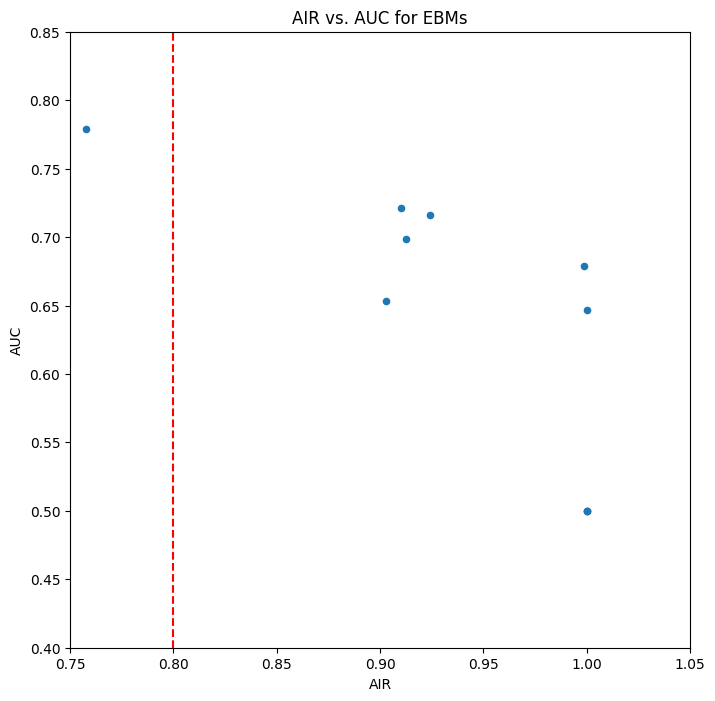

In [27]:
fig, ax = plt.subplots(figsize=(8,8))
_ = ebm_grid_frame.plot(kind='scatter', x='air', y='auc', title='AIR vs. AUC for EBMs', ax=ax)
_ = ax.axvline(x=0.8, color='r', linestyle='--')
_ = ax.set_ylim([0.4, 0.85])
_ = ax.set_xlim([0.75, 1.05])
_ = ax.set_xlabel('AIR')
_ = ax.set_ylabel('AUC')

#### Retrain most accurate model above 0.8 AIR

In [28]:
# extract new params dict from ebm_grid_frame
rem_params = ebm_grid_frame.loc[ebm_grid_frame['air'] > 0.8].sort_values(by='auc', ascending=False).iloc[0, :].to_dict()

# extract features from dict then delete from dict
rem_x_names = rem_params['features']
rem_x_names = [name.strip() for name in rem_x_names.split(',')]
del rem_params['features']

# record and delete other extraneous information
print('Best AUC: %.4f above 0.8 AIR (%.4f).' % (rem_params['auc'], rem_params['air']))
del rem_params['auc']
del rem_params['air']

# reset some parameters to integers
rem_params['random_state'] = int(rem_params['random_state'])
rem_params['n_jobs'] = int(rem_params['n_jobs'])
rem_params['early_stopping_rounds'] = int(rem_params['early_stopping_rounds'])

# retrain
rem_ebm = ExplainableBoostingClassifier(**rem_params)
rem_ebm.fit(train[rem_x_names], train[target])
rem_ebm_perf = ROC(rem_ebm.predict_proba).explain_perf(valid[rem_x_names], valid[target])
rem_auc = rem_ebm_perf._internal_obj['overall']['auc']
print('Remediated EBM retrained with AUC: %.4f.' % rem_auc)

Best AUC: 0.7212 above 0.8 AIR (0.9102).
Remediated EBM retrained with AUC: 0.7212.


#### Check that other groups are not adversely impacted by change

In [29]:
# create a frame with remediated EBM predictions
best_ebm_phat2 = pd.DataFrame(rem_ebm.predict_proba(valid[rem_x_names])[:, 1], columns=['phat'])
best_ebm_phat2 = pd.concat([valid.reset_index(drop=True), best_ebm_phat2], axis=1)

# calculate new confusion matrices for each group
rem_cm_dict2 = {}
for name in demographic_group_names:
    rem_cm_dict2[name] = get_confusion_matrix(best_ebm_phat2, target, 'phat', by=name, level=1, cutoff=0.17, verbose=False)

# calculate AIR for each group
print('Adverse impact ratio for Asian people vs. White people: %.3f' % air(rem_cm_dict2, 'white', 'asian', verbose=False))
print('Adverse impact ratio for Black people vs. White people: %.3f' % air(rem_cm_dict2, 'white', 'black', verbose=False))
print('Adverse impact ratio for Females vs. Males: %.3f' % air(rem_cm_dict2, 'male', 'female', verbose=False))

Adverse impact ratio for Asian people vs. White people: 1.166
Adverse impact ratio for Black people vs. White people: 0.910
Adverse impact ratio for Females vs. Males: 0.930


#### Print best model parameters for later use

In [30]:
rem_params

{'max_bins': 128,
 'max_interaction_bins': 32,
 'interactions': 5,
 'outer_bags': 12,
 'inner_bags': 0,
 'learning_rate': 0.01,
 'validation_size': 0.5,
 'min_samples_leaf': 1,
 'max_leaves': 5,
 'n_jobs': 4,
 'early_stopping_rounds': 100,
 'random_state': 12345}

#### Print best model features for later use

In [31]:
rem_x_names

['term_360',
 'debt_to_income_ratio_missing',
 'no_intro_rate_period_std',
 'conforming',
 'property_value_std']

#### Write submission file

In [32]:
rem_ebm_submit = pd.DataFrame(rem_ebm.predict_proba(test_data[rem_x_names])[:, 1], columns=['phat'])
rem_ebm_submit.to_csv('group3_ph_rem_ebm_baseline_' + str(datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S") + '.csv'),
                        index=False)